<a href="https://colab.research.google.com/github/eunyeongkimm/personal_project/blob/main/gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

# 예시 데이터 생성 (1000명 고객, 30일간의 시계열 데이터)
n_samples = 1000  # 고객 수
n_time_steps = 30  # 날짜 수 (30일간의 방문 데이터)
n_features = 1  # 시계열 특성 (페이지 방문 수)

# 시계열 데이터 (일별 방문 수)
np.random.seed(42)
time_series_data = np.random.poisson(lam=5, size=(n_samples, n_time_steps, n_features))  # 평균 5의 포아송 분포로 생성

# 비시계열 데이터 (고객 특성)
# 고객의 나이, 지역, 성별, 지출 점수, 충성도 점수
ages = np.random.randint(18, 65, n_samples)  # 18~65세
regions = np.random.choice(['Seoul', 'Busan', 'Incheon'], size=n_samples)  # 3개 지역
genders = np.random.choice(['Male', 'Female'], size=n_samples)  # 성별
spending_scores = np.random.uniform(50, 100, n_samples)  # 50~100 사이의 지출 점수
loyalty_scores = np.random.uniform(1.0, 5.0, n_samples)  # 1.0~5.0 사이의 충성도 점수

# 비시계열 특성 데이터 결합
non_time_series_data = np.column_stack([ages, regions, genders, spending_scores, loyalty_scores])

# 비시계열 데이터의 'region'과 'gender'를 카테고리형으로 변환 (예: one-hot encoding)
non_time_series_data[:, 1] = pd.Categorical(non_time_series_data[:, 1]).codes  # 'region' 카테고리 변환
non_time_series_data[:, 2] = pd.Categorical(non_time_series_data[:, 2]).codes  # 'gender' 카테고리 변환

# 데이터프레임으로 변환
df_time_series = pd.DataFrame(time_series_data.reshape(n_samples, -1), columns=[f"day_{i+1}" for i in range(n_time_steps)])
df_non_time_series = pd.DataFrame(non_time_series_data, columns=['age', 'region', 'gender', 'spending_score', 'loyalty_score'])

# 고객 ID(user_id) 추가
df_time_series['user_id'] = [f'user_{i+1}' for i in range(n_samples)]
df_non_time_series['user_id'] = [f'user_{i+1}' for i in range(n_samples)]

# 데이터 출력 (처리 성능을 위해 일부만 출력)
print("시계열 데이터 (시간에 따른 방문 수):")
print(df_time_series.head())

print("\n비시계열 데이터 (고객 특성):")
print(df_non_time_series.head())


시계열 데이터 (시간에 따른 방문 수):
   day_1  day_2  day_3  day_4  day_5  day_6  day_7  day_8  day_9  day_10  ...  \
0      5      4      4      5      5      3      5      4      6       7  ...   
1      5      3      8     10      3      2      5      7      6       6  ...   
2      3      4      8      2      2      2      7      6      7       6  ...   
3     10      6      9      4      1      6      8      6      2       3  ...   
4      3      7      7      6      6      7      8      6      3       7  ...   

   day_22  day_23  day_24  day_25  day_26  day_27  day_28  day_29  day_30  \
0       4       3       8       3       3       5       8       3       2   
1       5       4       3       8       2       1       4       5       4   
2       3       5       9       6       6       9       4       9       2   
3       5       6       2       4       7       6       5       4       3   
4       2       3       5       3       4       5       6       3       3   

   user_id  
0   user_1  
1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 시계열 데이터 및 비시계열 데이터 준비
X_time_series = df_time_series.drop(columns=['user_id']).values.reshape(-1, 30, 1)  # 시계열 데이터 (n_samples, n_time_steps, n_features)
X_non_time_series = df_non_time_series.drop(columns=['user_id']).values.astype(np.float32)  # 비시계열 특성
y = np.random.randint(0, 2, len(df_time_series))  # 이진 분류 타겟 값 (0 또는 1)

In [ ]:
X_time_series

array([[[ 5],
        [ 4],
        [ 4],
        ...,
        [ 8],
        [ 3],
        [ 2]],

       [[ 5],
        [ 3],
        [ 8],
        ...,
        [ 4],
        [ 5],
        [ 4]],

       [[ 3],
        [ 4],
        [ 8],
        ...,
        [ 4],
        [ 9],
        [ 2]],

       ...,

       [[10],
        [ 4],
        [ 3],
        ...,
        [ 6],
        [ 5],
        [ 4]],

       [[ 7],
        [ 9],
        [ 4],
        ...,
        [ 6],
        [ 7],
        [ 3]],

       [[ 6],
        [ 7],
        [ 6],
        ...,
        [ 5],
        [ 8],
        [ 0]]])

In [ ]:
# 데이터 표준화 (비시계열 특성만)
scaler = StandardScaler()
X_non_time_series = scaler.fit_transform(X_non_time_series)

In [ ]:
# 학습용, 테스트용 데이터 분할
X_train_ts, X_test_ts, X_train_non_ts, X_test_non_ts, y_train, y_test = train_test_split(
    X_time_series, X_non_time_series, y, test_size=0.2, random_state=42
)

In [ ]:
# 텐서로 변환
X_train_ts = torch.tensor(X_train_ts, dtype=torch.float32).to(device)
X_test_ts = torch.tensor(X_test_ts, dtype=torch.float32).to(device)
X_train_non_ts = torch.tensor(X_train_non_ts, dtype=torch.float32).to(device)
X_test_non_ts = torch.tensor(X_test_non_ts, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [ ]:
# 데이터로더 준비
train_dataset = TensorDataset(X_train_ts, X_train_non_ts, y_train)
test_dataset = TensorDataset(X_test_ts, X_test_non_ts, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# 모델 정의 (시그모이드 활성화 추가)
class TimeSeriesModel(nn.Module):
    def __init__(self, time_series_input_dim, non_time_series_input_dim):
        super(TimeSeriesModel, self).__init__()
        self.gru = nn.GRU(time_series_input_dim, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(non_time_series_input_dim, 16)
        self.fc3 = nn.Linear(32 + 16, 1)  # 이진 분류이므로 출력은 1 (확률값)

    def forward(self, time_series_input, non_time_series_input):
        # 시계열 데이터 처리
        gru_out, _ = self.gru(time_series_input)
        gru_out = gru_out[:, -1, :]  # 마지막 타임스텝의 출력

        # 비시계열 데이터 처리
        non_time_series_out = torch.relu(self.fc2(non_time_series_input))

        # 결합
        combined = torch.cat((gru_out, non_time_series_out), dim=1)
        output = self.fc3(combined)

        # 시그모이드 활성화 함수로 확률값 출력
        output = torch.sigmoid(output)  # 확률값으로 변환
        return output

In [ ]:
# 모델 인스턴스 생성
model = TimeSeriesModel(time_series_input_dim=1, non_time_series_input_dim=X_non_time_series.shape[1]).to(device)

In [ ]:
# 손실 함수 및 옵티마이저 정의 (이진 교차 엔트로피)
criterion = nn.BCEWithLogitsLoss()  # 시그모이드가 포함된 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class TimeSeriesModel(nn.Module):
    def __init__(self, time_series_input_dim, non_time_series_input_dim):
        super(TimeSeriesModel, self).__init__()
        self.gru = nn.GRU(time_series_input_dim, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 32)  # GRU 출력 크기 64에서 32로 변환
        self.fc2 = nn.Linear(non_time_series_input_dim, 16)  # 비시계열 특성 크기
        self.fc3 = nn.Linear(64 + 16, 1)  # GRU 출력(64)과 비시계열 출력(16)을 합친 크기 80을 입력으로 사용

    def forward(self, time_series_input, non_time_series_input):
        # 시계열 데이터 처리
        gru_out, _ = self.gru(time_series_input)
        gru_out = gru_out[:, -1, :]  # 마지막 타임스텝의 출력

        # 비시계열 데이터 처리
        non_time_series_out = torch.relu(self.fc2(non_time_series_input))

        # 두 출력을 결합하기 전에 차원 확인
        #print(f"gru_out shape: {gru_out.shape}, non_time_series_out shape: {non_time_series_out.shape}")

        # 결합
        combined = torch.cat((gru_out, non_time_series_out), dim=1)  # 두 텐서를 결합 (64 + 16 = 80)

        output = self.fc3(combined)  # 결합된 차원 80을 입력으로 처리

        # 시그모이드 활성화 함수로 확률값 출력
        output = torch.sigmoid(output)  # 확률값으로 변환
        return output


In [ ]:
# 모델 인스턴스 생성
model = TimeSeriesModel(time_series_input_dim=1, non_time_series_input_dim=X_non_time_series.shape[1]).to(device)

# 손실 함수 및 옵티마이저 정의 (이진 교차 엔트로피)
criterion = nn.BCEWithLogitsLoss()  # 시그모이드가 포함된 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# 모델 훈련
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        time_series_input, non_time_series_input, target = batch

        # 데이터 GPU로 전송
        time_series_input = time_series_input.to(device)
        non_time_series_input = non_time_series_input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        outputs = model(time_series_input, non_time_series_input)
        loss = criterion(outputs.squeeze(), target)  # target은 1D 벡터
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.7074
Epoch [2/10], Loss: 0.6963
Epoch [3/10], Loss: 0.6940
Epoch [4/10], Loss: 0.6930
Epoch [5/10], Loss: 0.6931
Epoch [6/10], Loss: 0.6934
Epoch [7/10], Loss: 0.6932
Epoch [8/10], Loss: 0.6932
Epoch [9/10], Loss: 0.6931
Epoch [10/10], Loss: 0.6929


Test AUC-ROC: 0.4736


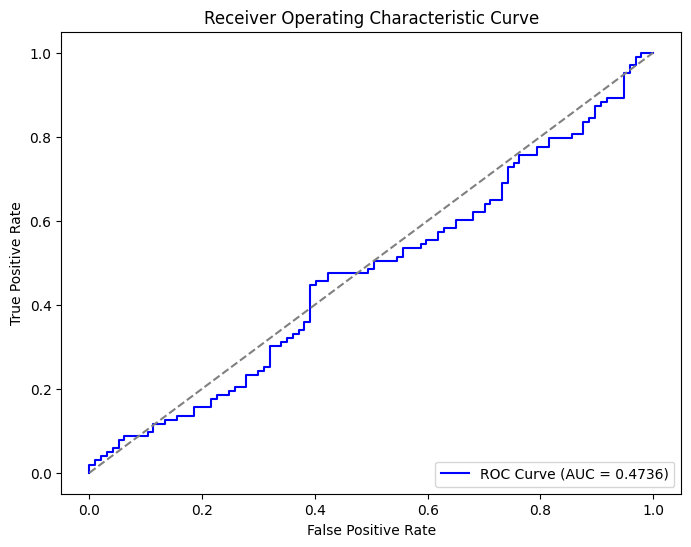

Test RMSE: 0.6963


In [ ]:
import torch
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 모델 평가
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for batch in test_loader:
        time_series_input, non_time_series_input, target = batch
        time_series_input = time_series_input.to(device)
        non_time_series_input = non_time_series_input.to(device)
        target = target.to(device)

        outputs = model(time_series_input, non_time_series_input)
        y_pred.append(outputs.squeeze().cpu().numpy())  # 예측 확률
        y_true.append(target.cpu().numpy())  # 실제값

    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    # AUC-ROC 계산
    auc = roc_auc_score(y_true, y_pred)
    print(f"Test AUC-ROC: {auc:.4f}")

    # AUC-ROC 커브 그리기
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 랜덤 분류기 (대각선)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc='lower right')
    plt.show()

    # RMSE 계산
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    print(f"Test RMSE: {rmse:.4f}")


In [8]:
import pandas as pd
import numpy as np

# 예시 데이터: VOC 수, 조회수, 날짜
data_voc = {
    'date': ['2024-01-03', '2024-01-06', '2024-01-31', '2024-01-05'],
    'user_id': ['12345678', '12345678', '12345678', '12121212'],
    'voc_count': [1, 2, 1, 1]
}
data_view = {
    'date': ['2024-01-01', '2024-01-02', '2024-01-31', '2024-01-05'],
    'user_id': ['12345678', '12345678', '12345678', '12121212'],
    'view_count': [33, 16, 11, 55]
}

# VOC 수와 조회수 데이터프레임 생성
df_voc = pd.DataFrame(data_voc)
df_view = pd.DataFrame(data_view)

# 날짜 형식으로 변환
df_voc['date'] = pd.to_datetime(df_voc['date'])
df_view['date'] = pd.to_datetime(df_view['date'])

# 날짜의 전체 범위 생성 (2024-01-01 ~ 2024-03-31)
date_range = pd.date_range(start='2024-01-01', end='2024-03-31')

# 유니크한 user_id에 대해 날짜 범위를 생성
user_ids = df_voc['user_id'].unique()  # 유니크 유저 아이디
all_dates = pd.MultiIndex.from_product([user_ids, date_range], names=['user_id', 'date'])

# MultiIndex를 DataFrame으로 변환 (reset_index로 컬럼화)
df_all_dates = all_dates.to_frame(index=False)

# VOC 수와 조회수 데이터를 각 유저별로 left join
df_voc_full = pd.merge(df_all_dates, df_voc[['user_id', 'date', 'voc_count']], on=['user_id', 'date'], how='left')
df_voc_full = pd.merge(df_voc_full, df_view[['user_id', 'date', 'view_count']], on=['user_id', 'date'], how='left')

# 결측값을 0으로 채우기
df_voc_full['voc_count'] = df_voc_full['voc_count'].fillna(0)
df_voc_full['view_count'] = df_voc_full['view_count'].fillna(0)

# 출력: 결측값 처리 후 일별 데이터
print("\n결측값 처리 후 일별 데이터:")
print(df_voc_full)



결측값 처리 후 일별 데이터:
      user_id       date  voc_count  view_count
0    12345678 2024-01-01        0.0        33.0
1    12345678 2024-01-02        0.0        16.0
2    12345678 2024-01-03        1.0         0.0
3    12345678 2024-01-04        0.0         0.0
4    12345678 2024-01-05        0.0         0.0
..        ...        ...        ...         ...
177  12121212 2024-03-27        0.0         0.0
178  12121212 2024-03-28        0.0         0.0
179  12121212 2024-03-29        0.0         0.0
180  12121212 2024-03-30        0.0         0.0
181  12121212 2024-03-31        0.0         0.0

[182 rows x 4 columns]


In [10]:
df_voc_full.head(90)

,user_id,date,voc_count,view_count
0,12345678,2024-01-01,0.0,33.0
1,12345678,2024-01-02,0.0,16.0
2,12345678,2024-01-03,1.0,0.0
3,12345678,2024-01-04,0.0,0.0
4,12345678,2024-01-05,0.0,0.0
...,...,...,...,...
85,12345678,2024-03-26,0.0,0.0
86,12345678,2024-03-27,0.0,0.0
87,12345678,2024-03-28,0.0,0.0
88,12345678,2024-03-29,0.0,0.0


In [11]:


# GRU 모델에 맞게 데이터 준비
time_steps = 90  # 시계열 길이 (예: 90일)
features = ['voc_count', 'view_count']  # 사용할 특성
n_samples = df_voc_full['user_id'].nunique()  # 유저 수

# 데이터프레임을 (samples, time_steps, features)로 변환
X = df_voc_full.groupby('user_id')[features].apply(
    lambda group: group.values[:time_steps]
).tolist()

# 리스트를 3D Numpy 배열로 변환
X = np.array(X)

print("\nGRU 모델 입력 데이터 (X):")
print(f"Shape: {X.shape}")  # (samples, time_steps, features)



GRU 모델 입력 데이터 (X):
Shape: (2, 90, 2)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# 데이터 준비
X_tensor = torch.tensor(X, dtype=torch.float32)  # 입력 데이터 (GRU 모델용)
y = np.random.randint(0, 2, size=(n_samples,))  # 이진 분류 레이블 (예시)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# GRU 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, h_n = self.gru(x)  # GRU의 마지막 은닉 상태(h_n)를 가져옴
        output = self.fc(h_n[-1])  # 마지막 은닉 상태를 FC 레이어에 통과
        return self.sigmoid(output)  # 이진 분류를 위해 sigmoid 활성화 사용

# 모델 인스턴스 생성
input_dim = 2  # 특성 수 (voc_count, view_count)
hidden_dim = 64  # GRU 은닉 상태 크기
output_dim = 1  # 이진 분류 출력
model = GRUModel(input_dim, hidden_dim, output_dim)

# 손실 함수와 옵티마이저
criterion = nn.BCELoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 데이터 로더 준비
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

# 모델 학습
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)  # 모델 출력
        loss = criterion(outputs.squeeze(-1), y_batch)  # squeeze(-1)로 마지막 차원만 제거
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


# 모델 평가
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
    y_pred_class = (y_pred > 0.5).astype(int)
    accuracy = (y_pred_class == y_test.numpy()).mean()
    print(f"Test Accuracy: {accuracy:.4f}")


Epoch [1/10], Loss: 0.7338
Epoch [2/10], Loss: 0.7229
Epoch [3/10], Loss: 0.7120
Epoch [4/10], Loss: 0.7010
Epoch [5/10], Loss: 0.6900
Epoch [6/10], Loss: 0.6788
Epoch [7/10], Loss: 0.6675
Epoch [8/10], Loss: 0.6559
Epoch [9/10], Loss: 0.6441
Epoch [10/10], Loss: 0.6319
Test Accuracy: 0.0000
